# Tutorial HowToAdaptiveOptics

This report provides a tutorial to use the code develloped to compute the PSIM for the ELT SCAO systems. 
The code is object-oriented and its architecture is quite inspired from the ([OOMAO simulator](https://github.com/cmcorreia/LAM-Public/tree/master/_libOomao)).



## Modules required
The code is written in Python 3 and requires the following modules

* **aotools**        => simulation of the phase screens
* **numba**          => required in aotools
* **joblib**         => paralleling computing
* **scikit-image**   => 2D interpolations
* **numexpr**        => memory optimized simple operations
* **astropy**        => handling of fits files

To be able to use the code you need to install the listed modules using the following command lines in a terminal:

*pip install aotools*

*pip install numba*

*pip install joblib*

*pip install scikit-image*

*pip install numexpr*

*pip install astropy*


### Import Modules

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 21 10:51:32 2020

@author: cheritie
"""
# commom modules
import matplotlib.pyplot as plt
import numpy             as np 
import time

# adding AO_Module to the path
import __load__psim
__load__psim.load_psim()

# loading AO modules
from AO_modules.Atmosphere       import Atmosphere
from AO_modules.Pyramid          import Pyramid
from AO_modules.DeformableMirror import DeformableMirror
from AO_modules.MisRegistration  import MisRegistration
from AO_modules.Telescope        import Telescope
from AO_modules.Source           import Source

# calibration modules 
from AO_modules.calibration.compute_KL import compute_M2C
from AO_modules.calibration.ao_calibration import ao_calibration

# display modules
from AO_modules.tools.displayTools           import displayMap


Looking for AO_Modules...
['../AO_modules']
AO_Modules found! Loading the main modules:


### Read Parameter File

In [2]:
#import parameter file (dictionnary)

from parameterFile_VLT_I_Band import initializeParameterFile

param = initializeParameterFile()
# the list of the keys contained in the dictionnary can be printed using the following lines
# for key, value in param.items() :
#     print (key, value)

Reading/Writting calibration data from /Disk3/cheritier/psim/data_calibration/
Writting output data in /diskb/cheritier/psim/data_cl
Creation of the directory /diskb/cheritier/psim/data_cl failed:
Directory already exists!


## Telescope Object

In [3]:
# create the Telescope object
tel = Telescope(resolution          = param['resolution'],\
                diameter            = param['diameter'],\
                samplingTime        = param['samplingTime'],\
                centralObstruction  = param['centralObstruction'])

NGS flux updated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.55 	 [microns]
Optical Band 	V
Magnitude 	-0.0
Flux 		8967391304.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.55 	 [microns]
Optical Band 	V
Magnitude 	-0.0
Flux 		8967391304.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Diameter 			8 	 [m]
Resolution 			180 	 [pix]
Pixel Size 			0.04	 [m]
Surface 			50.0	 [m2]
Central Obstruction 		0	 [% of diameter]
Number of pixel in the pupil 	25448 	 [pix]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


The mai informations contained in the telescope objects are the following: 
* tel. pupil : the pupil of the telescope as a 2D mask

* tel.src    : the source object attached to the telescope that contains the informations related to the wavelength, flux and phase. The default wavelength is the V band with a magnitude 0.

* tel.OPD    : the telescope OPD corresponding to the tel.src.phase 

All the properties of an object can be displayed using the .show() method: 

In [4]:
tel.show()

telescope:
          D: 8
          OPD: (180, 180)
          centralObstruction: 0
          fov: 0
          index_pixel_petals: None
          isPaired: False
          isPetalFree: False
          pixelArea: 25448
          pixelSize: 0.044444444444444446
          pupil: (180, 180)
          pupilLogical: (1, 25448)
          pupilReflectivity: (180, 180)
          resolution: 180
          samplingTime: 0.001
          src: source object
          tag: telescope


We can show the 2D map corresponding to the pupil or to the OPD:

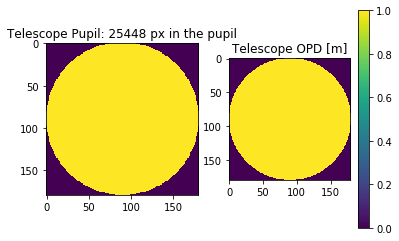

In [5]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(tel.pupil.T)
plt.title('Telescope Pupil: %.0f px in the pupil' %tel.pixelArea)
plt.subplot(1,2,2)
plt.imshow(tel.OPD.T)
plt.title('Telescope OPD [m]')
plt.colorbar()

And we can display the property of the child class tel.src that correspond to the default source object attached to the telescope:

In [6]:
tel.src.show()

source:
          bandwidth: 9e-08
          magnitude: -0.0
          nPhoton: 8967391304.347826
          optBand: V
          phase: (180, 180)
          tag: source
          wavelength: 5.5e-07
          zeroPoint: 8967391304.347826


## Source Object
The Source object allows to access the properties related to the flux and wavelength of the object. We consider only on-axis objects as a start. 

In [7]:
ngs=Source(optBand   = param['opticalBand'],\
           magnitude = param['magnitude'])
print('NGS Object built!')

NGS flux updated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.79 	 [microns]
Optical Band 	I
Magnitude 	8.0
Flux 		4629307.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.79 	 [microns]
Optical Band 	I
Magnitude 	8.0
Flux 		4629307.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
NGS Object built!


The NGS object has to be attached to a telescope object using the ***** operator. 

This operation sets the telescope property tel.src to the ngs object considered. 

In [8]:
ngs*tel

The ngs object is now attached to the telescope. This means that the tel.src object now has a **phase** and a **fluxMap** property.

If we display the properties of ngs and tel.src, they are the same: 

In [9]:
# properties of ngs
ngs.show()
# properties of tel.src
tel.src.show()

source:
          bandwidth: 1.5e-07
          fluxMap: (180, 180)
          magnitude: 8.0
          nPhoton: 4629306.603523155
          optBand: I
          phase: (180, 180)
          tag: source
          var: 8548456070609.184
          wavelength: 7.9e-07
          zeroPoint: 7336956521.73913
source:
          bandwidth: 1.5e-07
          fluxMap: (180, 180)
          magnitude: 8.0
          nPhoton: 4629306.603523155
          optBand: I
          phase: (180, 180)
          tag: source
          var: 8548456070609.184
          wavelength: 7.9e-07
          zeroPoint: 7336956521.73913


We can compute and display the PSF corresponding to the telescope OPD and Source object attached to the telescope. 

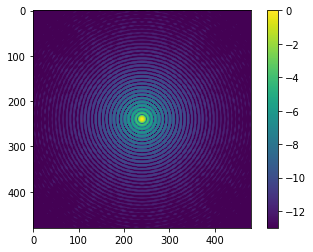

In [37]:

zeroPaddingFactor = 8

tel.computePSF(zeroPaddingFactor = zeroPaddingFactor)

PSF_normalized = tel.PSF/tel.PSF.max()

nPix = zeroPaddingFactor*tel.resolution//3

plt.figure()
plt.imshow(np.log(np.abs(PSF_normalized[nPix:-nPix,nPix:-nPix])))
plt.clim([-13,0])
plt.colorbar()



## Atmosphere Object
The atmosphere object is created mainly from the telescope properties (diameter, pupil, samplingTime)and the *r0* and *L0* parameters. It is possible to generate multi-layers, each one is a child-class of the atmosphere object with its own set of parameters (windSpeed, Cn^2,windDirection, altitude). 


In [39]:
atm=Atmosphere(telescope     = tel,\
               r0            = param['r0'],\
               L0            = param['L0'],\
               windSpeed     = param['windSpeed'],\
               fractionalR0  = param['fractionnalR0'],\
               windDirection = param['windDirection'],\
               altitude      = param['altitude'])

print('Atmosphere Object built!')

Atmosphere Object built!


The atmosphere object has to be initialized using:

In [40]:
# initialize atmosphere
atm.initializeAtmosphere(tel)
print('Done!')

Creation of layer1/1 ...
-> Computing the initial phase screen...
initial phase screen : 0.04688215255737305 s
ZZt.. : 2.476616859436035 s
ZXt.. : 1.2607417106628418 s
XXt.. : 0.6290159225463867 s
Done!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% ATMOSPHERE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
r0 		0.13 	 [m]
L0 		30 	 [m]
Seeing(V) 	0.79	 ["]
------------------------------------------------------------------------
Layer 	 Direction 	 Speed 		 Altitude
1 	 0 [deg] 	 10 [m/s] 	100 [m]
------------------------------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Done!


Similarly to the Source object, the atmosphere object can be paired to the telescope **+**. 

In that case, if the atmosphere OPD is updated, the telescope OPD is automatically updated.

In [42]:
tel+atm
print(tel.isPaired)

Telescope and Atmosphere combined!
True


We can display the properties of the telescope object:

Text(0.5, 1.0, 'NGS Phase [rad]')

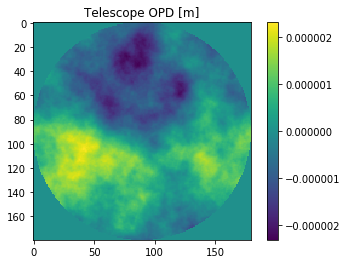

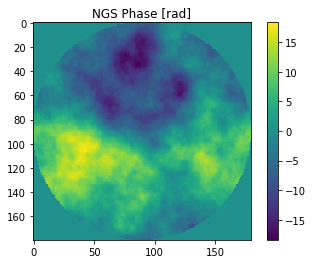

In [43]:
plt.figure()
plt.imshow(tel.OPD.T)
plt.title('Telescope OPD [m]')
plt.colorbar()

plt.figure()
plt.imshow(tel.src.phase.T)
plt.colorbar()
plt.title('NGS Phase [rad]')

The atmosphere and the telescope can be separated using the **-** operator. This brings back the system to a diffraction limited case with a flat OPD.

In [44]:
tel-atm
print(tel.isPaired)

Telescope and Atmosphere separated!
False


## Deformable Mirror Object
The deformable mirror is mainly characterized with its influence functions. They can be user-defined and loaded in the model but the default case is a cartesian DM with gaussian influence functions and normalized to 1. 
The DM is always defined in the pupil plane. 


In [45]:
dm=DeformableMirror(telescope    = tel,\
                    nSubap       = param['nSubaperture'],\
                    mechCoupling = param['mechanicalCoupling'])
print('Done!')

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DEFORMABLE MIRROR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Controlled Actuators 	 777
Pitch 			 0.26666666666666666 	 [m]
Mechanical Coupling 	 0.45 	 [m]
Rotation: 0 deg -- shift X: 0 m -- shift Y: 0 m -- Anamorphosis Angle: 0 deg -- Radial Scaling: 0 -- Tangential Scaling: 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Done!


We can display the cube of the influence functions to display the position of the actuators.


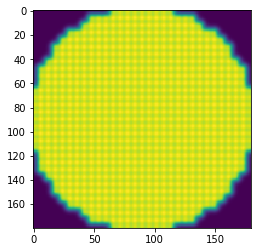

In [47]:
cube_IF = np.reshape(np.sum(dm.modes**3, axis =1),[tel.resolution,tel.resolution])
plt.figure()
plt.imshow(cube_IF.T)

### Light propagation
The light can be propagate through the DM using the ***** operator. 

To update the DM surface, the property **dm.coefs** must be updated to set the new values of the DM coefficients.

Typically, using a random command vector, we can propagate the light through the DM (light is reflected hence the sign change and the factor 2 in OPD):

Telescope and Atmosphere separated!


Text(0.5, 1.0, 'Telescope OPD [m]')

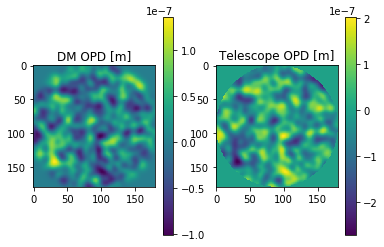

In [48]:
tel-atm

dm.coefs = (np.random.rand(dm.nValidAct)-0.5)*100e-9
tel*dm
plt.figure()
plt.subplot(121)
plt.imshow(dm.OPD)
plt.title('DM OPD [m]')
plt.colorbar()
plt.subplot(122)
plt.imshow(tel.OPD)
plt.colorbar()
plt.title('Telescope OPD [m]')

### Mis-registrations
The DM/WFS mis-registrations are applied directly in the DM space, applying the transformations on the DM influence functions. 

First we create a **MisRegistration Object** that is initialized to 0. 

We can then update the values of the mis-registrations and input it to the DM model:

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DEFORMABLE MIRROR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Controlled Actuators 	 777
Pitch 			 0.26666666666666666 	 [m]
Mechanical Coupling 	 0.45 	 [m]
Rotation: 3 deg -- shift X: 0.08 m -- shift Y: 0.07 m -- Anamorphosis Angle: 0 deg -- Radial Scaling: 0 -- Tangential Scaling: 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Done!


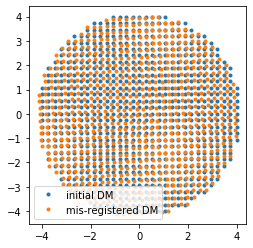

In [49]:
misReg = MisRegistration()
misReg.rotationAngle = 3
misReg.shiftX        = 0.3*param['diameter']/param['nSubaperture']
misReg.shiftY        = 0.25*param['diameter']/param['nSubaperture']

dm_misReg = DeformableMirror(telescope    = tel,\
                    nSubap       = param['nSubaperture'],\
                    mechCoupling = param['mechanicalCoupling'],\
                    misReg       = misReg)
print('Done!')

plt.figure()
plt.plot(dm.coordinates[:,0],dm.coordinates[:,1],'.')
plt.plot(dm_misReg.coordinates[:,0],dm_misReg.coordinates[:,1],'.')
plt.axis('square')
plt.legend(['initial DM','mis-registered DM'])


## Pyramid Object
The pyramid object consists mainly in defining the PWFS mask to apply the filtering of the electro-magnetic field. 
Many parameters can allow to tune the pyramid model:
* Centering of the mask and of the FFT on 1 or 4 pixels
* Modulation radius in λ/D. By default the number of modulation points ensures to have one point every λ/D on the circular trajectory but this sampling can be modified by the user. The number of modulation points is a multiple of 4 to ensure that each quadrant has the same number of modulation points.
* The modulation value for the calibration and selection of the valid pixels
* PWFS pupils separation, either for a perfect pyramid with a single value or for an imperfect pyramid with 8 values (shift X and Y for each PWFS pupil) . 
* The type of post-processing of the PWFS signals (slopes-maps, full-frame,etc). To be independent from this choice, the pyramid signals are named “wfs.pyramidSignal_2D” for either the Slopes-Maps or the camera frame and “wfs.pyramidSignal” for the signal reduced to the valid pixels considered.
* The intensity threshold to select the valid pixel 

Some optional features can be user-defined:
* Zero-padding value
* Number of  pixel on the edge of the Pyramid pupils
* The units of the WFS signals can be calibrated using a ramp of Tip/Tilt


In addition, the Pyramid object has a Detector object as a child-class that provides the pyramid signals. It can be access through **wfs.cam**

In [50]:
# make sure tel and atm are separated to initialize the PWFS
tel-atm

# create the Pyramid Object
wfs = Pyramid(nSubap                = param['nSubaperture'],\
              telescope             = tel,\
              modulation            = param['modulation'],\
              lightRatio            = param['lightThreshold'],\
              pupilSeparationRatio  = param['pupilSeparationRatio'],\
              calibModulation       = param['calibrationModulation'],\
              psfCentering          = param['psfCentering'],\
              edgePixel             = param['edgePixel'],\
              unitCalibration       = param['unitCalibration'],\
              extraModulationFactor = param['extraModulationFactor'],\
              postProcessing        = param['postProcessing'])


Telescope and Atmosphere separated!
Pyramid Mask initialization...
Done!
Selection of the valid pixels...
The valid pixel are selected on flux considerations
Done!
Acquisition of the reference slopes and units calibration...
WFS calibrated!
Done!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PYRAMID WFS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Pupils Diameter 	30 	 [pixels]
Pupils Separation 	5.999999999999998 	 [pixels]
Pixel Size 		0.27	 [m]
TT Modulation 		3 	 [lamda/D]
PSF Core Sampling 	1 	 [pixel(s)]
Signal Post-Processing 	fullFrame
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


The light can be propagated to the WFS through the different objects with using the ***** operator:

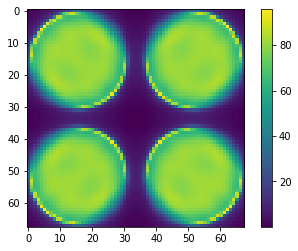

In [51]:
tel*wfs

plt.figure()
plt.imshow(wfs.cam.frame)
plt.colorbar()

We can display the PWFS signals that corresponds to a random actuation of the DM:

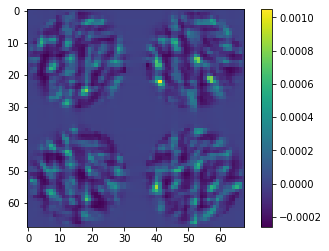

In [52]:
dm.coefs = (np.random.rand(dm.nValidAct)-0.5)*100e-9
tel*dm*wfs

plt.figure()
plt.imshow(wfs.pyramidSignal_2D)
plt.colorbar()

## Modal Basis
In this tutorial, we compute the mode-to-commands matrix (M2C) using the codes provided by C.Verinaud. It corresponds to a KL modal basis orthogonolized in the DM space.

In [54]:
foldername_M2C  = None  # name of the folder to save the M2C matrix, if None a default name is used 
filename_M2C    = None  # name of the filename, if None a default name is used 


M2C =  compute_M2C(param            = param,\
                  telescope         = tel,\
                  atmosphere        = atm,\
                  deformableMirror  = dm,\
                  nameFolder        = None,\
                  nameFile          = None)

Computing Forced modes PTT...
VECTORIFYING INFLUENCE FUNCTIONS...
COMPUTING DELTA AND ITS INVERSE...                                
 DELTA DONE...
GRAMM SCHMIDT ON FORCED MODES...
VECTORIZING PTT PHASE SHAPES...
COMPUTING COMMANDS FOR PTT...
EXECUTING GRAMM-SCMIDT ORTHOGONALIZATION...
NORMALIZING MODES...
GRAMM SCHMIDT ON FORCED MODES: DONE
 
FORCED MODES MAX ORTHONORMALITY ERROR =  2.3224938961773423e-09
 
STARTING FORCED DM EIGENMODES COMPUTATION...
1ST DIAGONALIZATION...
DONE. FORCED DM_EIGEN MODES TOOK:  0.40918803215026855
 
VERIFYING FORCED DM EIGENMODES ...
MAX FORCED DM EIGENMODES ORTHONORMALITY ERROR =  2.3224939155027944e-09
BLOCKL / REST =  388 1
 
 
 
STARTING STATISTICAL DM/ATM COVARIANCE MATRIX COMPUTATION...
COMPUTING HiHj...
 
CREATING FFTW PLANS...
NCL =  3
 
Expanding IFMs... 0 0
 
EXECUTING ... 0 0
STARTED NE WORK  A ... 0 0
FINISHED NE WORK A ... 0 0
STARTED SHIFTING  A ... 0 0
FINISHED SHIFTING  A ... 0 0
STARTED FFT  A ... 0 0
FINISHED FFT  A ... 0 0
STARTED SHIF

## Interaction Matrix
The interaction matrix can be computed using the M2C matrix and the function interactionMatrix.
The output is stored as a class that contains all the informations about the inversion (SVD) such as eigenValues, reconstructor, etc. 

It is possible to add a **phaseOffset** to the interactionMatrix measurement. 

In [57]:
#%% to manually measure the interaction matrix
#
## amplitude of the modes in m
#stroke=1e-9
## Modal Interaction Matrix 
#M2C = M2C[:,:param['nModes']]
#from AO_modules.calibration.InteractionMatrix import interactionMatrix
#
#calib = interactionMatrix(ngs            = ngs,\
#                             atm            = atm,\
#                             tel            = tel,\
#                             dm             = dm,\
#                             wfs            = wfs,\
#                             M2C            = M2C,\
#                             stroke         = stroke,\
#                             phaseOffset    = 0,\
#                             nMeasurements  = 100,\
#                             noise          = False)
#
#plt.figure()
#plt.plot(np.std(calib.D,axis=0))
#plt.xlabel('Mode Number')
#plt.ylabel('WFS slopes STD')
#plt.ylabel('Optical Gain')

In [58]:
ao_calib =  ao_calibration(param            = param,\
                           ngs              = ngs,\
                           tel              = tel,\
                           atm              = atm,\
                           dm               = dm,\
                           wfs              = wfs,\
                           nameFolderIntMat = None,\
                           nameIntMat       = None,\
                           nameFolderBasis  = None,\
                           nameBasis        = None,\
                           nMeasurements    = 100)


Creation of the directory /Disk3/cheritier/psim/data_calibration/ failed:
Directory already exists!
Loading the KL Modal Basis from: /Disk3/cheritier/psim/data_calibration/M2C_180_res
Creation of the directory /Disk3/cheritier/psim/data_calibration/VLT_I_band_30x30/ failed:
Directory already exists!
Loading Interaction matrix zonal_interaction_matrix_180_res_3_mod_fullFrame_psfCentering_False...
Done!
No Modal Gains found. All gains set to 1


In [62]:
## Display Modal Basis


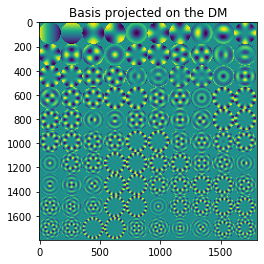

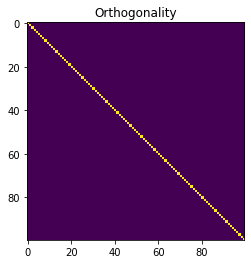

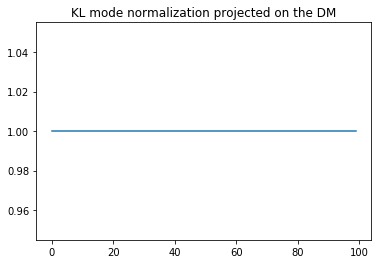

In [63]:

# project the mode on the DM
dm.coefs = ao_calib.M2C[:,:100]

tel*dm
#
# show the modes projected on the dm, cropped by the pupil and normalized by their maximum value
displayMap(tel.OPD,norma=True)
plt.title('Basis projected on the DM')

KL_dm = np.reshape(tel.OPD,[tel.resolution**2,tel.OPD.shape[2]])

covMat = (KL_dm.T @ KL_dm) / tel.resolution**2

plt.figure()
plt.imshow(covMat)
plt.title('Orthogonality')
plt.show()

plt.figure()
plt.plot(np.round(np.std(np.squeeze(KL_dm[tel.pupilLogical,:]),axis = 0),5))
plt.title('KL mode normalization projected on the DM')
plt.show()


## Closed Loop
Here is a code to do a closed-loop simulation using the PSIM code:

Telescope and Atmosphere combined!


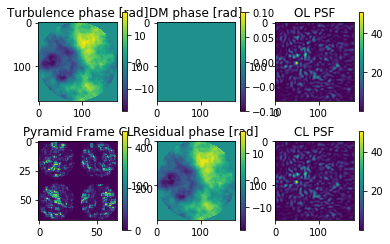

Elapsed time: 0.6780838966369629 s


<Figure size 432x288 with 0 Axes>

Loop0/100 Turbulence: 969.3247495137168 -- Residual:969.3247495137168

Elapsed time: 0.7334802150726318 s


<Figure size 432x288 with 0 Axes>

Loop1/100 Turbulence: 969.3885375905827 -- Residual:969.3885375905827

Elapsed time: 0.6733250617980957 s


<Figure size 432x288 with 0 Axes>

Loop2/100 Turbulence: 969.4166537263822 -- Residual:836.4674494031298

Elapsed time: 0.6655890941619873 s


<Figure size 432x288 with 0 Axes>

Loop3/100 Turbulence: 969.4904142965253 -- Residual:710.0006734354483

Elapsed time: 0.6346676349639893 s


<Figure size 432x288 with 0 Axes>

Loop4/100 Turbulence: 969.6400293883138 -- Residual:581.7820847196518

Elapsed time: 0.6832113265991211 s


<Figure size 432x288 with 0 Axes>

Loop5/100 Turbulence: 969.7526528882411 -- Residual:458.9111532390337

Elapsed time: 0.7221615314483643 s


<Figure size 432x288 with 0 Axes>

Loop6/100 Turbulence: 969.79934956104 -- Residual:349.4751372282247

Elapsed time: 0.7318105697631836 s


<Figure size 432x288 with 0 Axes>

Loop7/100 Turbulence: 969.8472292293549 -- Residual:254.80006345541224

Elapsed time: 0.6392624378204346 s


<Figure size 432x288 with 0 Axes>

Loop8/100 Turbulence: 969.9758221691048 -- Residual:175.43388740510474

Elapsed time: 0.7266631126403809 s


<Figure size 432x288 with 0 Axes>

Loop9/100 Turbulence: 970.1338544800414 -- Residual:116.68192690134094

Elapsed time: 0.732323408126831 s


<Figure size 432x288 with 0 Axes>

Loop10/100 Turbulence: 970.2031382457207 -- Residual:87.40362441994935

Elapsed time: 0.6741602420806885 s


<Figure size 432x288 with 0 Axes>

Loop11/100 Turbulence: 970.2298140095154 -- Residual:81.70042950473571

Elapsed time: 0.6628139019012451 s


<Figure size 432x288 with 0 Axes>

Loop12/100 Turbulence: 970.3086284221594 -- Residual:81.69519352513245

Elapsed time: 0.6690685749053955 s


<Figure size 432x288 with 0 Axes>

Loop13/100 Turbulence: 970.4596788167755 -- Residual:80.84071484789554

Elapsed time: 0.6820228099822998 s


<Figure size 432x288 with 0 Axes>

Loop14/100 Turbulence: 970.5634745420667 -- Residual:80.28505441806335

Elapsed time: 0.7328486442565918 s


<Figure size 432x288 with 0 Axes>

Loop15/100 Turbulence: 970.5902559716156 -- Residual:79.56531946045435

Elapsed time: 0.6848249435424805 s


<Figure size 432x288 with 0 Axes>

Loop16/100 Turbulence: 970.6139555947518 -- Residual:79.20903466312744

Elapsed time: 0.6907289028167725 s


<Figure size 432x288 with 0 Axes>

Loop17/100 Turbulence: 970.7218489340871 -- Residual:79.04575780248722

Elapsed time: 0.8099141120910645 s


<Figure size 432x288 with 0 Axes>

Loop18/100 Turbulence: 970.8592164290798 -- Residual:79.72784333056103

Elapsed time: 0.9460062980651855 s


<Figure size 432x288 with 0 Axes>

Loop19/100 Turbulence: 970.9134168334137 -- Residual:79.51855521238049

Elapsed time: 0.6739115715026855 s


<Figure size 432x288 with 0 Axes>

Loop20/100 Turbulence: 970.927412953667 -- Residual:78.30631707416023

Elapsed time: 0.7175500392913818 s


<Figure size 432x288 with 0 Axes>

Loop21/100 Turbulence: 971.0064551935427 -- Residual:77.8019826110538

Elapsed time: 0.6853504180908203 s


<Figure size 432x288 with 0 Axes>

Loop22/100 Turbulence: 971.1572919561413 -- Residual:78.08501412093739

Elapsed time: 0.7443616390228271 s


<Figure size 432x288 with 0 Axes>

Loop23/100 Turbulence: 971.254835270352 -- Residual:78.42101766186151

Elapsed time: 0.6359822750091553 s


<Figure size 432x288 with 0 Axes>

Loop24/100 Turbulence: 971.2651244171259 -- Residual:77.6082474398949

Elapsed time: 0.7580490112304688 s


<Figure size 432x288 with 0 Axes>

Loop25/100 Turbulence: 971.2853195034562 -- Residual:77.10956812822785

Elapsed time: 0.6510219573974609 s


<Figure size 432x288 with 0 Axes>

Loop26/100 Turbulence: 971.3918987781814 -- Residual:77.63926497540577

Elapsed time: 0.6766531467437744 s


<Figure size 432x288 with 0 Axes>

Loop27/100 Turbulence: 971.5166095698928 -- Residual:78.49398459907528

Elapsed time: 0.7410399913787842 s


<Figure size 432x288 with 0 Axes>

Loop28/100 Turbulence: 971.5467454896637 -- Residual:78.23824267952466

Elapsed time: 0.6732969284057617 s


<Figure size 432x288 with 0 Axes>

Loop29/100 Turbulence: 971.5336798584182 -- Residual:77.17098073838189

Elapsed time: 0.6371300220489502 s


<Figure size 432x288 with 0 Axes>

Loop30/100 Turbulence: 971.5908769967425 -- Residual:77.18695274193655

Elapsed time: 0.6683592796325684 s


<Figure size 432x288 with 0 Axes>

Loop31/100 Turbulence: 971.7169913264072 -- Residual:78.11002547385682

Elapsed time: 0.7389967441558838 s


<Figure size 432x288 with 0 Axes>

Loop32/100 Turbulence: 971.7871290977804 -- Residual:78.41633939140665

Elapsed time: 0.7132337093353271 s


<Figure size 432x288 with 0 Axes>

Loop33/100 Turbulence: 971.7696925430492 -- Residual:77.54606094509026

Elapsed time: 0.6666347980499268 s


<Figure size 432x288 with 0 Axes>

Loop34/100 Turbulence: 971.7793349843204 -- Residual:76.90662144763382

Elapsed time: 0.7052314281463623 s


<Figure size 432x288 with 0 Axes>

Loop35/100 Turbulence: 971.880428788973 -- Residual:77.81700255773542

Elapsed time: 0.698246955871582 s


<Figure size 432x288 with 0 Axes>

Loop36/100 Turbulence: 971.9905453452388 -- Residual:79.00700763823637

Elapsed time: 0.7352566719055176 s


<Figure size 432x288 with 0 Axes>

Loop37/100 Turbulence: 971.9978305430893 -- Residual:78.7343078641908

Elapsed time: 0.6973340511322021 s


<Figure size 432x288 with 0 Axes>

Loop38/100 Turbulence: 971.9748487341495 -- Residual:78.01491147414359

Elapsed time: 0.7229762077331543 s


<Figure size 432x288 with 0 Axes>

Loop39/100 Turbulence: 972.0340195470236 -- Residual:78.23517773774304

Elapsed time: 0.7106049060821533 s


<Figure size 432x288 with 0 Axes>

Loop40/100 Turbulence: 972.1585425602972 -- Residual:79.47135865106677

Elapsed time: 0.7765560150146484 s


<Figure size 432x288 with 0 Axes>

Loop41/100 Turbulence: 972.2177902467696 -- Residual:79.88263794577695

Elapsed time: 0.7079637050628662 s


<Figure size 432x288 with 0 Axes>

Loop42/100 Turbulence: 972.1934145519722 -- Residual:79.17290998224631

Elapsed time: 0.684258222579956 s


<Figure size 432x288 with 0 Axes>

Loop43/100 Turbulence: 972.2109270503503 -- Residual:78.60958927113028

Elapsed time: 0.6851651668548584 s


<Figure size 432x288 with 0 Axes>

Loop44/100 Turbulence: 972.3221078142374 -- Residual:79.22506474627603

Elapsed time: 0.6812334060668945 s


<Figure size 432x288 with 0 Axes>

Loop45/100 Turbulence: 972.4326347865099 -- Residual:79.6690427977594

Elapsed time: 0.7366561889648438 s


<Figure size 432x288 with 0 Axes>

Loop46/100 Turbulence: 972.4370959235382 -- Residual:79.18762920381312

Elapsed time: 0.656726598739624 s


<Figure size 432x288 with 0 Axes>

Loop47/100 Turbulence: 972.4244745214289 -- Residual:78.4716322756717

Elapsed time: 0.6818413734436035 s


<Figure size 432x288 with 0 Axes>

Loop48/100 Turbulence: 972.5031799506324 -- Residual:78.66837260665865

Elapsed time: 0.6943633556365967 s


<Figure size 432x288 with 0 Axes>

Loop49/100 Turbulence: 972.643541658893 -- Residual:79.41039910859543

Elapsed time: 0.7457873821258545 s


<Figure size 432x288 with 0 Axes>

Loop50/100 Turbulence: 972.7088639238632 -- Residual:79.32089166687017

Elapsed time: 0.6734094619750977 s


<Figure size 432x288 with 0 Axes>

Loop51/100 Turbulence: 972.6955317847767 -- Residual:77.95300010343031

Elapsed time: 0.7044589519500732 s


<Figure size 432x288 with 0 Axes>

Loop52/100 Turbulence: 972.7394291410801 -- Residual:77.76157712053488

Elapsed time: 0.8038246631622314 s


<Figure size 432x288 with 0 Axes>

Loop53/100 Turbulence: 972.8793910896393 -- Residual:78.80054530443884

Elapsed time: 0.7081279754638672 s


<Figure size 432x288 with 0 Axes>

Loop54/100 Turbulence: 973.0100982858605 -- Residual:79.2442382617507

Elapsed time: 0.7481560707092285 s


<Figure size 432x288 with 0 Axes>

Loop55/100 Turbulence: 973.031001990723 -- Residual:78.45746656656415

Elapsed time: 0.6440074443817139 s


<Figure size 432x288 with 0 Axes>

Loop56/100 Turbulence: 973.0517491639972 -- Residual:77.72041414871566

Elapsed time: 0.729790210723877 s


<Figure size 432x288 with 0 Axes>

Loop57/100 Turbulence: 973.1689100278656 -- Residual:78.03850185645068

Elapsed time: 0.706416130065918 s


<Figure size 432x288 with 0 Axes>

Loop58/100 Turbulence: 973.3345467819012 -- Residual:78.87365444691741

Elapsed time: 0.7495789527893066 s


<Figure size 432x288 with 0 Axes>

Loop59/100 Turbulence: 973.404087090137 -- Residual:78.82403387492101

Elapsed time: 0.7212107181549072 s


<Figure size 432x288 with 0 Axes>

Loop60/100 Turbulence: 973.3977566393307 -- Residual:78.02946930652759

Elapsed time: 0.6454343795776367 s


<Figure size 432x288 with 0 Axes>

Loop61/100 Turbulence: 973.4544497336211 -- Residual:77.9195797541134

Elapsed time: 0.7074887752532959 s


<Figure size 432x288 with 0 Axes>

Loop62/100 Turbulence: 973.59819098667 -- Residual:78.75658721061978

Elapsed time: 0.7640595436096191 s


<Figure size 432x288 with 0 Axes>

Loop63/100 Turbulence: 973.7126710704301 -- Residual:78.99264862413926

Elapsed time: 0.6869821548461914 s


<Figure size 432x288 with 0 Axes>

Loop64/100 Turbulence: 973.7088470353176 -- Residual:78.00436499171506

Elapsed time: 0.664121150970459 s


<Figure size 432x288 with 0 Axes>

Loop65/100 Turbulence: 973.7112975079789 -- Residual:77.35036862112888

Elapsed time: 0.6588072776794434 s


<Figure size 432x288 with 0 Axes>

Loop66/100 Turbulence: 973.808935856834 -- Residual:78.20952283389495

Elapsed time: 0.6953966617584229 s


<Figure size 432x288 with 0 Axes>

Loop67/100 Turbulence: 973.943104526482 -- Residual:79.26896289394112

Elapsed time: 0.5051343441009521 s


<Figure size 432x288 with 0 Axes>

Loop68/100 Turbulence: 973.9722210578005 -- Residual:78.98087646084056

Elapsed time: 0.4916110038757324 s


<Figure size 432x288 with 0 Axes>

Loop69/100 Turbulence: 973.9409019506792 -- Residual:77.94776913913336

Elapsed time: 0.5032687187194824 s


<Figure size 432x288 with 0 Axes>

Loop70/100 Turbulence: 973.982439132869 -- Residual:77.9915598706848

Elapsed time: 0.5201025009155273 s


<Figure size 432x288 with 0 Axes>

Loop71/100 Turbulence: 974.1027880665055 -- Residual:78.67746643069262

Elapsed time: 0.5155048370361328 s


<Figure size 432x288 with 0 Axes>

Loop72/100 Turbulence: 974.1727133160146 -- Residual:78.8293198770642

Elapsed time: 0.5240838527679443 s


<Figure size 432x288 with 0 Axes>

Loop73/100 Turbulence: 974.1241828225322 -- Residual:77.99768701768518

Elapsed time: 0.6522107124328613 s


<Figure size 432x288 with 0 Axes>

Loop74/100 Turbulence: 974.095783790475 -- Residual:77.26609905813963

Elapsed time: 0.6785376071929932 s


<Figure size 432x288 with 0 Axes>

Loop75/100 Turbulence: 974.1619221134982 -- Residual:77.85008166474509

Elapsed time: 0.6971120834350586 s


<Figure size 432x288 with 0 Axes>

Loop76/100 Turbulence: 974.2477937037183 -- Residual:78.84563459168304

Elapsed time: 0.7298600673675537 s


<Figure size 432x288 with 0 Axes>

Loop77/100 Turbulence: 974.217103765808 -- Residual:78.74683525364505

Elapsed time: 0.6130139827728271 s


<Figure size 432x288 with 0 Axes>

Loop78/100 Turbulence: 974.1393075124499 -- Residual:77.6981008738075

Elapsed time: 0.6604409217834473 s


<Figure size 432x288 with 0 Axes>

Loop79/100 Turbulence: 974.1403822179025 -- Residual:77.67761998970958

Elapsed time: 0.6190953254699707 s


<Figure size 432x288 with 0 Axes>

Loop80/100 Turbulence: 974.2105028275231 -- Residual:78.85687309507767

Elapsed time: 0.6257407665252686 s


<Figure size 432x288 with 0 Axes>

Loop81/100 Turbulence: 974.212321706968 -- Residual:78.80530065992177

Elapsed time: 0.7021355628967285 s


<Figure size 432x288 with 0 Axes>

Loop82/100 Turbulence: 974.1038280588828 -- Residual:77.72311862332054

Elapsed time: 0.5535573959350586 s


<Figure size 432x288 with 0 Axes>

Loop83/100 Turbulence: 974.0290395439124 -- Residual:77.31235118671624

Elapsed time: 0.5667562484741211 s


<Figure size 432x288 with 0 Axes>

Loop84/100 Turbulence: 974.0466737642515 -- Residual:78.08381577066714

Elapsed time: 0.6209371089935303 s


<Figure size 432x288 with 0 Axes>

Loop85/100 Turbulence: 974.0663231177234 -- Residual:78.9233374865536

Elapsed time: 0.7237396240234375 s


<Figure size 432x288 with 0 Axes>

Loop86/100 Turbulence: 973.9616800751414 -- Residual:78.31923229902385

Elapsed time: 0.585946798324585 s


<Figure size 432x288 with 0 Axes>

Loop87/100 Turbulence: 973.825895785101 -- Residual:77.48082318524588

Elapsed time: 0.6665897369384766 s


<Figure size 432x288 with 0 Axes>

Loop88/100 Turbulence: 973.77406854614 -- Residual:77.65266939679972

Elapsed time: 0.6830530166625977 s


<Figure size 432x288 with 0 Axes>

Loop89/100 Turbulence: 973.7791820383408 -- Residual:78.63767949659464

Elapsed time: 0.7086596488952637 s


<Figure size 432x288 with 0 Axes>

Loop90/100 Turbulence: 973.6994169861158 -- Residual:78.56694161280782

Elapsed time: 0.6332638263702393 s


<Figure size 432x288 with 0 Axes>

Loop91/100 Turbulence: 973.5231708810442 -- Residual:77.69011690930353

Elapsed time: 0.6851775646209717 s


<Figure size 432x288 with 0 Axes>

Loop92/100 Turbulence: 973.3942327568818 -- Residual:77.26626482107194

Elapsed time: 0.7071397304534912 s


<Figure size 432x288 with 0 Axes>

Loop93/100 Turbulence: 973.3542908131849 -- Residual:78.12364499625194

Elapsed time: 0.7070236206054688 s


<Figure size 432x288 with 0 Axes>

Loop94/100 Turbulence: 973.2977433672651 -- Residual:78.94363583392024

Elapsed time: 0.7628366947174072 s


<Figure size 432x288 with 0 Axes>

Loop95/100 Turbulence: 973.1189159091759 -- Residual:78.57016788186347

Elapsed time: 0.6117439270019531 s


<Figure size 432x288 with 0 Axes>

Loop96/100 Turbulence: 972.9292586438421 -- Residual:77.62225175774724

Elapsed time: 0.6857411861419678 s


<Figure size 432x288 with 0 Axes>

Loop97/100 Turbulence: 972.8306611585757 -- Residual:77.96715815616454

Elapsed time: 0.679678201675415 s


<Figure size 432x288 with 0 Axes>

Loop98/100 Turbulence: 972.7773156100541 -- Residual:78.91525687040192

Elapsed time: 0.7549428939819336 s


<Figure size 432x288 with 0 Axes>

Loop99/100 Turbulence: 972.6279512925572 -- Residual:78.76392283716612



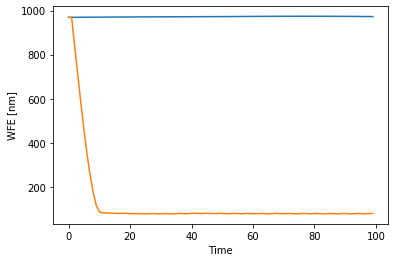

In [65]:

# These are the calibration data used to close the loop
calib_CL    = ao_calib.calib
M2C_CL      = ao_calib.M2C

param['nLoop'] =100
plt.close('all')

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79)
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF_trunc)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF_trunc)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
wfsSignal               = np.arange(0,wfs.nSignal)*0

# loop parameters
gainCL                  = 0.6
wfs.cam.photonNoise     = True
display                 = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if display == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF_trunc/tel.PSF_trunc.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)
       
     # propagate to the WFS with the CL commands applied
    tel*dm*wfs
    
     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength
    
    dm.coefs=dm.coefs-gainCL*M2C_CL@calib_CL.M@wfsSignal
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.pyramidSignal
    b= time.time()
    print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:
        
       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())
     
       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max()) 
    
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF.set_data(np.log(tel.PSF_trunc/tel.PSF_trunc.max()))
       im_PSF.set_clim(vmin=-4,vmax=0)
       plt.draw()
       plt.show()
       plt.pause(0.001)
    
    
    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

    print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')

#%%
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time')
plt.ylabel('WFE [nm]')

plt.pause(10)
